<center><h1>Implementation of SaShiMi</h1><h3>From paper <a href="https://arxiv.org/abs/2202.09729">It's Raw! Audio Generation with State-Space Models</a></h3></center>

Generate audio from raw samples. Can be used as a CNN or RNN.

# Prelude

Setup, import modules, select device, etc.

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Dataset

The dataset is actually just the audio track of [this 4 hour piano video from YouTube](https://www.youtube.com/watch?v=EhO_MrRfftU). It's resampled at 16 kHZ and divided into 1 minute WAV files. Thankfully, the authors of the paper have already done this step and uploaded the processed dataset [here on HuggingFace](https://huggingface.co/datasets/krandiash/youtubemix).

In [4]:
train_dataset = YoutubeMixDataset("../datasets/youtube-mix/train", device=device)

In [5]:
len(train_dataset)

1589

In [6]:
# Check sample rate
assert train_dataset.sample_rate == 16000

x, y = train_dataset[0]
assert list(x.size()) == [8 * 16000]
assert list(y.size()) == [8 * 16000]

`x` contains samples 0 to N in the sound file, each sample is a float between -1 and +1. `y`, on the other hand, contains samples 1 to N+1, each sample is an integer between 0 to 255. For each input sample $i$, the network predicts the probabilities for the next sample ($i+1$) in 8-bits using the inputs from $0$ to $i$.

Let's listen to one of the sound files in the dataset:

In [7]:
ipd.Audio(x.cpu().numpy(), rate=16000)

In [8]:
x, y = train_dataset[7]
ipd.Audio(x.cpu().numpy(), rate=16000)

# SaShiMi Architecture

Here, we borrow Figure 1 from the paper:

<img src="images/sashimi-architecture.png" alt="SaShiMi Figure"/>


## S4 Layer

At a high-level, S4 layer can be thought of as a mapping from a 1D sequence to another 1D sequence. Some of the important properties of S4:
- It's causal. The output at index $i$ depends on inputs from $0$ to $i-1$.
- It can be computed using either convolution or recurrence.
    - We use convolution during training and recurrence during sampling.
- Although it's 1D to 1D, we stack multiple S4 Layers together to process multidimensional signals.
    - In this case, different dimensions don't interact with each other.
    - Linear layers compute interactions between different signal dimensions but they cannot handle interactions through time. Therefore, linear layers complement S4 layers nicely.
- S4 doesn't provide non-linearity by itself. It needs to be combined with activation functions.

For more information, you can read the [paper](https://arxiv.org/abs/2202.09729) or the source code of our S4 implementation. Our code contains many docstrings and comments.

## S4 Block

The main component of SaShiMi architecture is the **S4 Block**. The paper explains the details of S4 block in Appendix A.2.

### High-level Architecture

First pass:
1. Input
2. LayerNorm
3. S4 Layer
4. GELU
5. Linear
6. Residual connection from 1

Second pass:
1. Output of the first pass
2. LayerNorm
3. Linear
4. GELU
5. Linear
6. Residual connection from 1

All linear layers are position-wise, i.e., they operate on the signal dimensions, not
the time dimension.

### Implementation

Once the S4 layer is implemented, constructing an S4 block is easy.

The following function constructs the S4 block from these arguments:
- `signal_dim`: Number of dimensions in the signal.
- `state_dim`: Number of dimensions in inner state.
- `sequence_length`: The length of the sequence on which this model will operate.
    - Can be changed later, but models trained on one sequence length perform poorly on another sequence length.
- `expansion_factor`: The factor by which the number of dimensions will be multiplied between two linear layers in the second pass.

Note that we use our own `Sequential` implementation instead of `torch.nn.Sequential`. Our implementation inherits `torch.nn.Sequential` and accounts for the S4 layer when we want to run it in recurrent mode. `Residual` is the same as `Sequential` but it applies a residual connection from the beginning to the end, i.e., $Residual(x) = x + Sequential(x)$.

## Up-Pool and Down-Pool

The next components **up-pool** and **down-pool** are combinations of reshaping and a linear layer.

In particular, for an input of shape $(T, H)$ where $T$ is the sequence length (sample count) and $H$ is the signal dimension, the **down-pool** is

$$
(T,H) \xrightarrow{\text{reshape}} (T/p, H \cdot p) \xrightarrow{\text{linear}} (T/p, H \cdot q)
$$

where $p$ is the pooling factor and $q$ is the expansion factor.

**Up-pool** is simply the opposite operation:

$$
(T/p, H \cdot q) \xrightarrow{\text{linear}} (T/p, H \cdot p) \xrightarrow{\text{reshape}} (T,H)
$$

They use $p=4$ and $q=2$ in the paper.

There's also a **bidirectional S4** variant presented in the paper, which is simply the concatenation of two S4 layers but one of them is run in reverse order. However, obviously it's not used for autoregressive tasks. Thus, we won't implement it in this notebook.

## Overall Architecture

Now, we have all the components required to implement the SaShiMi architecture given in Figure 1.

# Overfitting Test

In accordance with the well-respected 796 tradition, we first test whether the model works by trying to overfit into a single example.

In [12]:
torch.manual_seed(42)

model = SaShiMi(
    input_dim=1,
    hidden_dim=128,
    output_dim=256,
    state_dim=64,
    sequence_length=16000*8,
    block_count=2,
).to(device)

Freeze $p$, $B$ and $dt$ parameters (see Appendix C.2.1 in the paper).

In [13]:
for module in model.modules():
    # isinstance doesn't work due to automatic reloading
    if type(module).__name__ == S4Base.__name__:
        module.B.requires_grad = False
        module.P.requires_grad = False
        module.log_step.requires_grad = False

In [14]:
x, y = train_dataset[0]
overfit_dataset = [(x, y)]

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

  0%|          | 0/1000 [00:00<?, ?it/s]

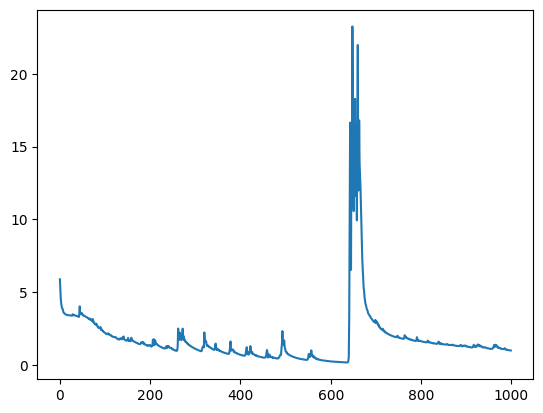

In [16]:
model.train()
for epoch in tqdm(range(1000), leave=False):
    train_loss = 0.0
    for x, y in overfit_dataset:
        y_hat = model(x.unsqueeze(1))
        loss = criterion(y_hat.view(-1, 256), y.view(-1))

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.show()

## Convolutional Sample

In [17]:
model.eval()
with torch.no_grad():
    x, y = overfit_dataset[0]
    y_hat = model(x.unsqueeze(1))
    sample = ((torch.argmax(y_hat, dim=-1).flatten() / 255.0) - 0.5) * 2.0

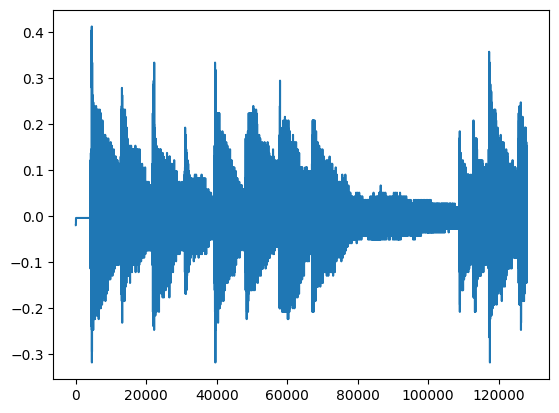

In [18]:
sample = sample.cpu()
plt.plot(sample)
ipd.Audio(sample.numpy(), rate=16000)

## Recurrent Sample

In [19]:
def generate_sample(m, count: int, priming_signal=None, maxp=False):
    f = m.get_recurrent_runner()
    # The input is padded with 0 at the start
    u = f(torch.zeros(1, device=device))

    # Process the priming signal if given
    if priming_signal is not None:
        for s in priming_signal:
            u = f(s)
        primed_size = priming_signal.size(0)
    else:
        primed_size = 0

    # Generate the new part
    Y = []
    for _ in range(count - primed_size):
        if maxp:
            p = torch.argmax(u)
        else:
            dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
            p = dist.sample()
        p = (p / 255.0) * 2.0 - 1.0
        Y.append(p)
        u = p.reshape(1)
        u = f(u)

    generated = torch.stack(Y).real
    if priming_signal is not None:
        priming_signal = priming_signal.flatten()
        return torch.cat([priming_signal, generated], dim=0)
    else:
        return generated

In [22]:
model.eval()
with torch.no_grad():
    gen = generate_sample(model, 8*16000).cpu()

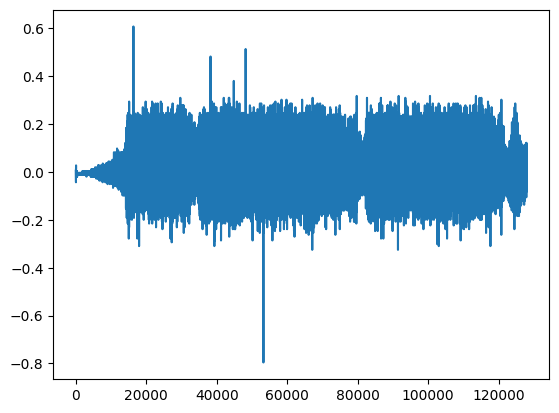

In [23]:
plt.figure()
plt.plot(gen)
ipd.Audio(gen.flatten().numpy(), rate=16000)

In [72]:
torch.save(model, "../models/sashimi-ym-overfit.pt")

In [81]:
model = torch.load("../models/sashimi-ym-overfit.pt")

# Debug

In [83]:
%pdb

Automatic pdb calling has been turned OFF


In [87]:
torch.cuda.memory_allocated()

313236992

In [88]:
sum([i.nelement() for i in model.parameters()])

6656518

In [46]:
import torch, gc
gc.collect()

4293

In [47]:
torch.cuda.empty_cache()

In [48]:
torch.cuda.memory_allocated()

140238848